In [90]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
library(survminer)
source("../../../src/tools.R")
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

In [118]:

tmp <-read.table('handovercompiled.Yanis.080919.csv',sep=",",header=T)
rownames(tmp) <- tmp$data_pd
cols_to_keep <- colnames(tmp)
master <- read.table('../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
df <- read.table('../../clustering/clustering_Final_1/df_final_full_component_ITD.tsv')
df_merge <- merge(df,master[,cols_to_keep],by=0)
rownames(df_merge) <- df_merge$Row.names
df_merge <- df_merge[-1]

# keep only patients with AML 17

df_merge$AMLID <- as.character(df_merge$AMLID)
df_merge$MRD1 <- as.character(df_merge$MRD1)
df_merge <- df_merge[grep("17-", df_merge$AMLID),]
df_merge$MRD_status <- ifelse(df_merge$MRD1=="CR,MRD-" ,"CR,MRD-",
                         ifelse(df_merge$MRD1=="CR,MRD+" ,"CR,MRD+","_others"))   ## _others instead of others for color purposes
df_merge[is.na(df_merge$MRD_status),"MRD_status"] <- "_others"

In [119]:
# set_notebook_plot_size(20,10)
plots_KM_MRD <- function(tmp=df_merge,fit,strat="all"){

    if (dim(tmp)[1]>20){
        
        ## specific p value
        m <- "no pvalue"
        try(res <- pairwise_survdiff(Surv(RFSyears, RFSStatus)~MRD_status,data = tmp))
        try(if(res$p.value["CR,MRD+","CR,MRD-"] <0.0001){
            m <- paste("p <0.0001")
        }else if(res$p.value["CR,MRD+","CR,MRD-"] >0.0001){
            m <- paste("p = ",round(res$p.value["CR,MRD+","CR,MRD-"],4),sep="")
        }else {m <- "no pvalue"})
        ##
   
        p <- ggsurvplot(fit,  pval = m,pval.coord=c(0,0.01),
                            main = "Survival curve ",risk.table=T,submain = paste("Kaplan-Meier estimates Relapse Free Survival for ",strat,sep=""),palette=c("#59A08B","#EE9937","#5C5C5C","#0072B2"),linetype=c(3,1,1,1),
                          ggtheme = theme_survminer(
                         font.main = c(16, "bold", "darkblue"),
                         font.submain = c(15, "bold.italic", "purple"),
                         font.caption = c(14, "plain", "orange"),
                         font.x = c(14, "bold.italic", "red"),
                         font.y = c(14, "bold.italic", "darkred"),
                         font.tickslab = c(12, "plain", "darkgreen")))
            
            
        surv_object <- Surv(time = tmp$OS_CR, event = tmp$DEADStatus)
        fit <- survfit(surv_object ~ MRD_status, data = tmp)
            
        ## specific p value
        m <- "no pvalue"
        try(res <- pairwise_survdiff(Surv(OS_CR, DEADStatus)~MRD_status,data = tmp))
        try(if(res$p.value["CR,MRD+","CR,MRD-"] <0.0001){
            m <- paste("p <0.0001")
        }else if(res$p.value["CR,MRD+","CR,MRD-"] >0.0001){
            m <- paste("p = ",round(res$p.value["CR,MRD+","CR,MRD-"],4),sep="")
        }else {m <- "no pvalue"}
            )
        ## 

        q <- ggsurvplot(fit,  pval = m ,pval.coord=c(0,0.01),
                            main = "Survival curve ",risk.table=T,submain = paste("Kaplan-Meier estimates OS_CR for ",strat,sep=""),palette=c("#59A08B","#EE9937","#5C5C5C","#0072B2"),linetype=c(3,1,1,1),
                          ggtheme = theme_survminer(
                         font.main = c(16, "bold", "darkblue"),
                         font.submain = c(15, "bold.italic", "purple"),
                         font.caption = c(14, "plain", "orange"),
                         font.x = c(14, "bold.italic", "red"),
                         font.y = c(14, "bold.italic", "darkred"),
                         font.tickslab = c(12, "plain", "darkgreen")))
        arrange_ggsurvplots(list(p,q),ncol=2)
        }
}

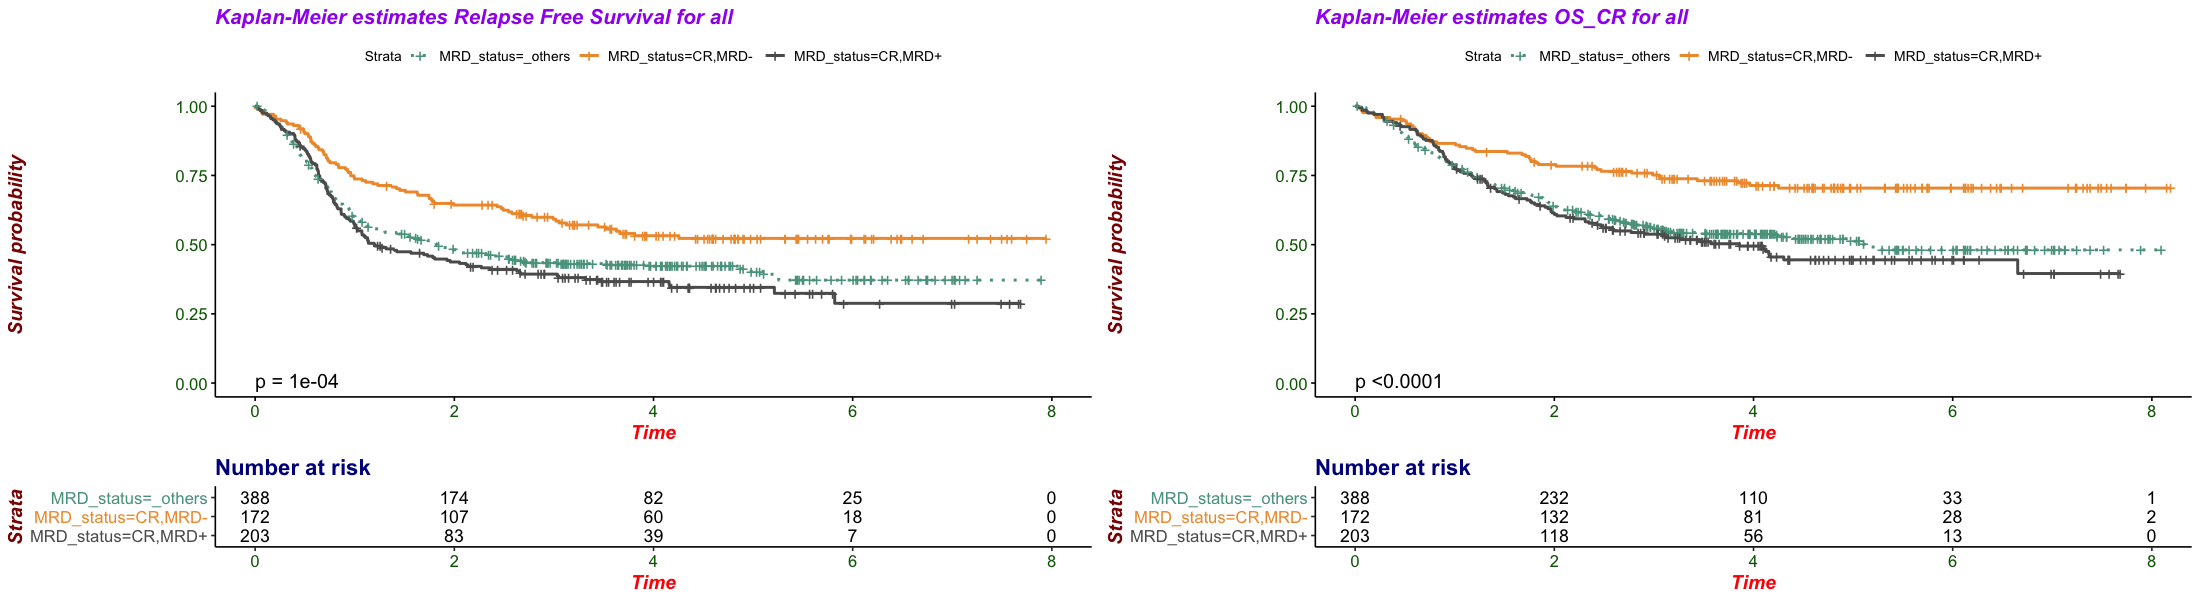

In [122]:
# pdf("graphs/MRD/overall_MRD.pdf",22,6)
tmp<- df_merge
surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
fit <- survfit(surv_object ~ MRD_status, data = tmp)
plots_KM_MRD(tmp,fit)
# dev.off()

# CR MRD Stratification by component

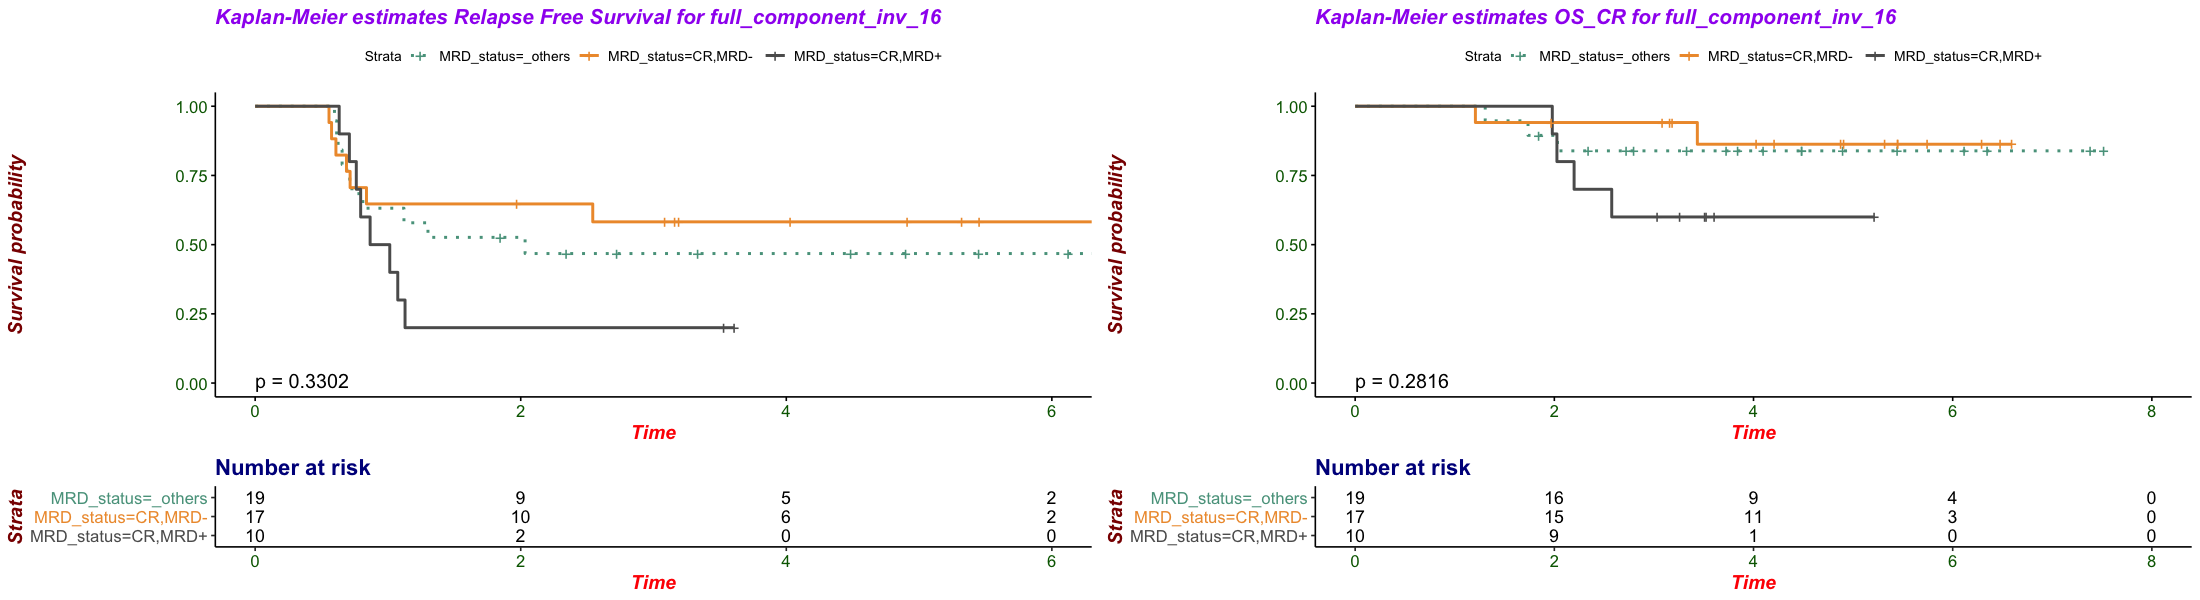

Warning message in max(event[who2]):
“no non-missing arguments to max; returning -Inf”

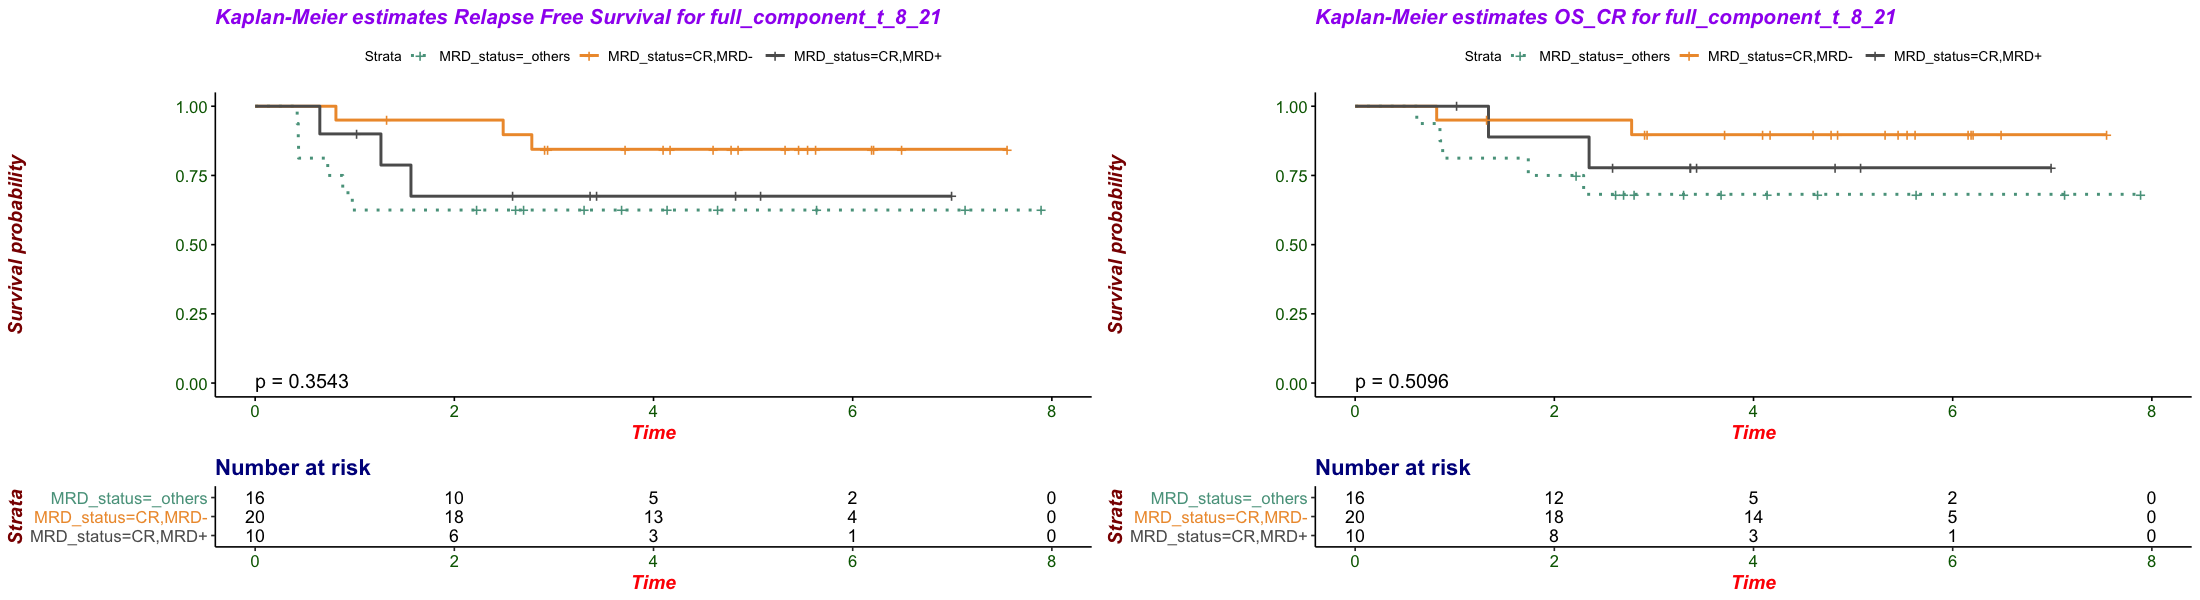

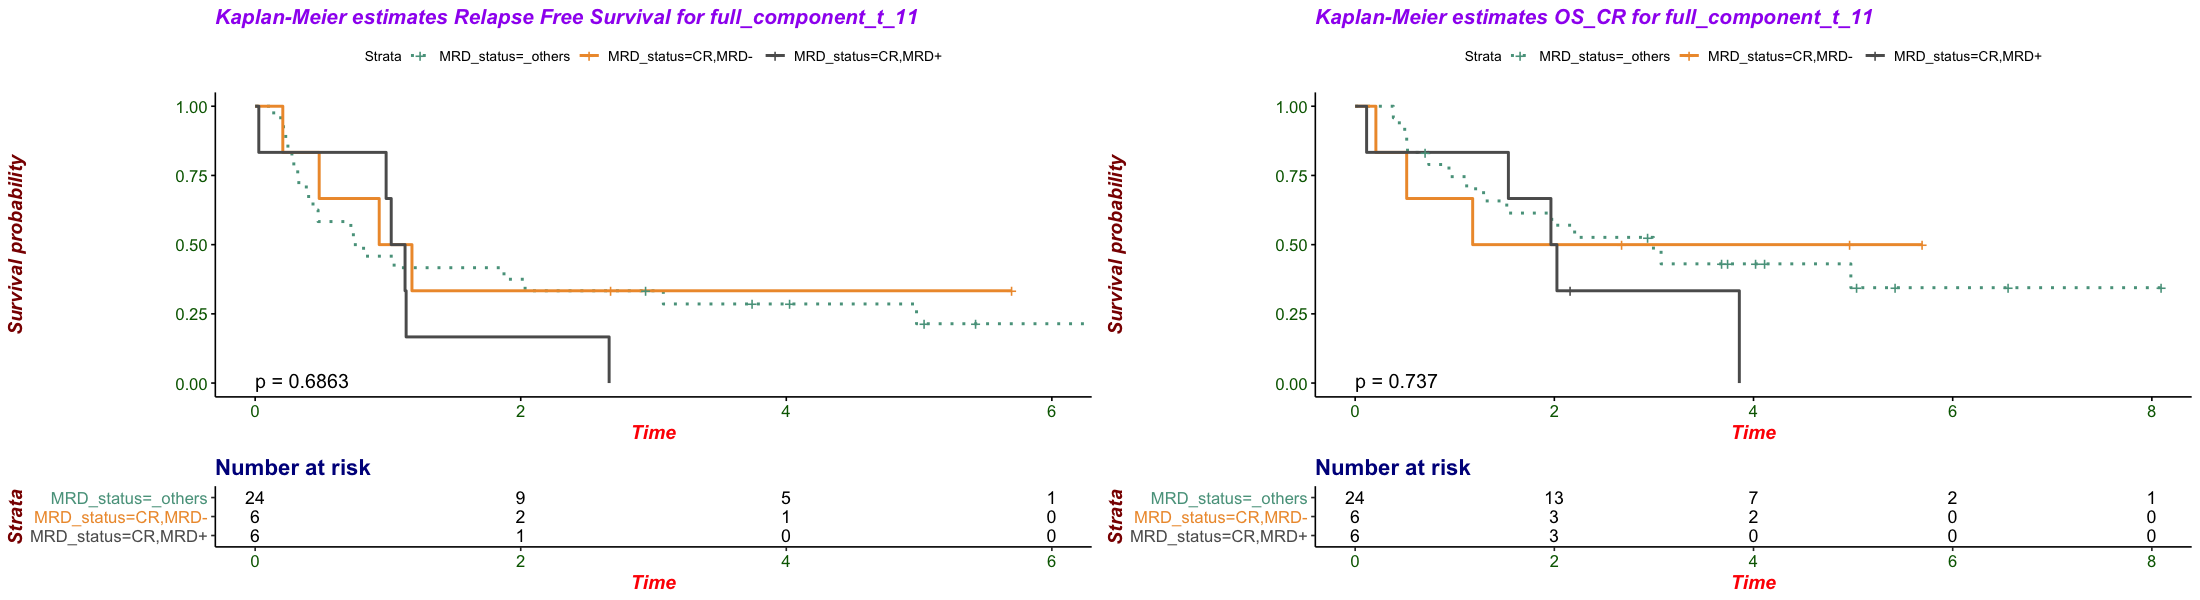

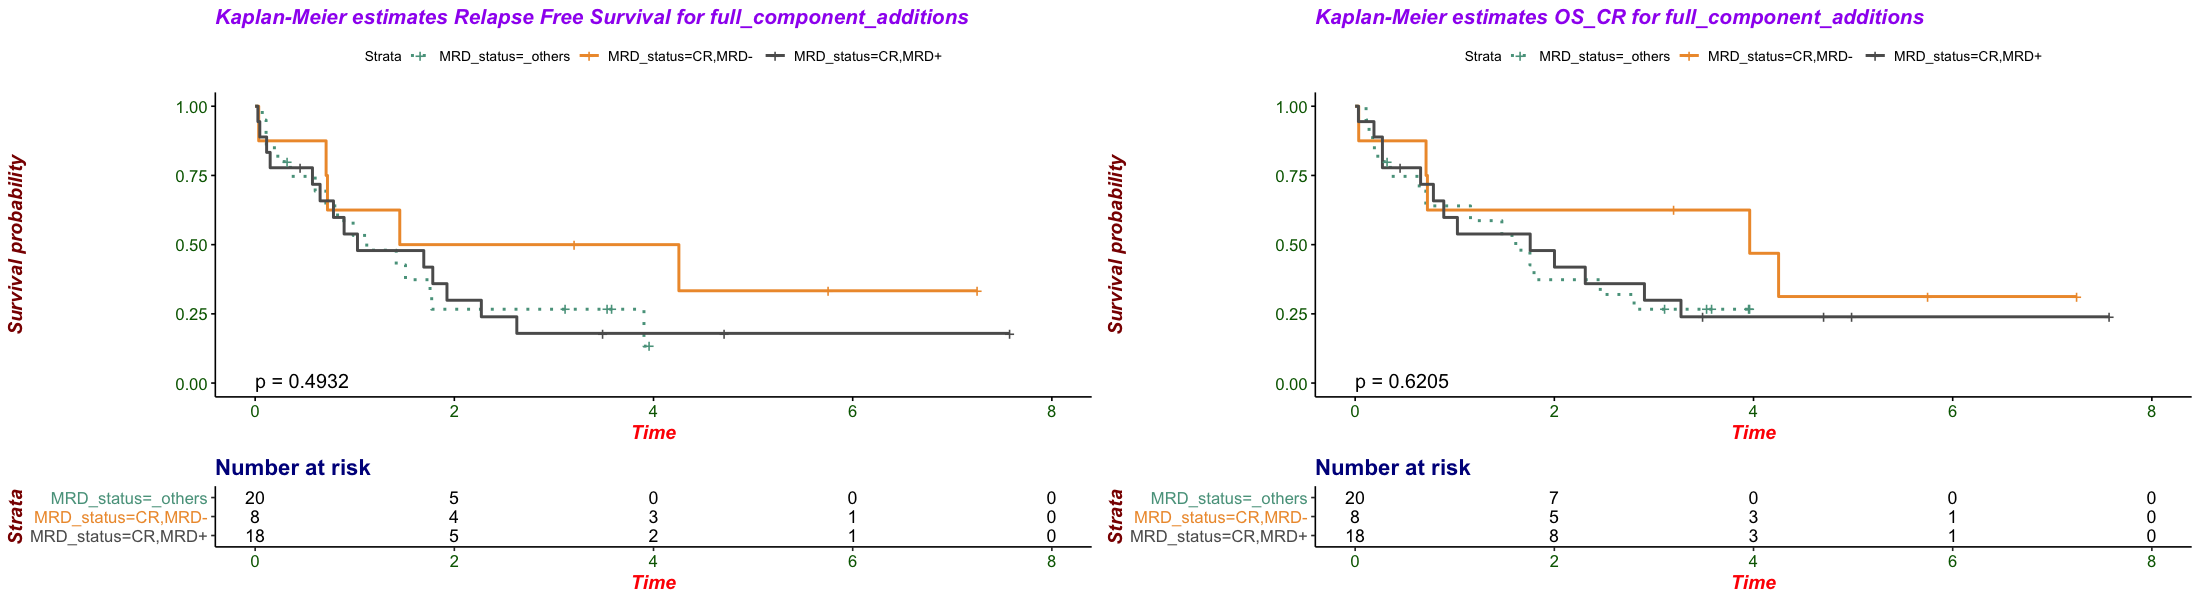

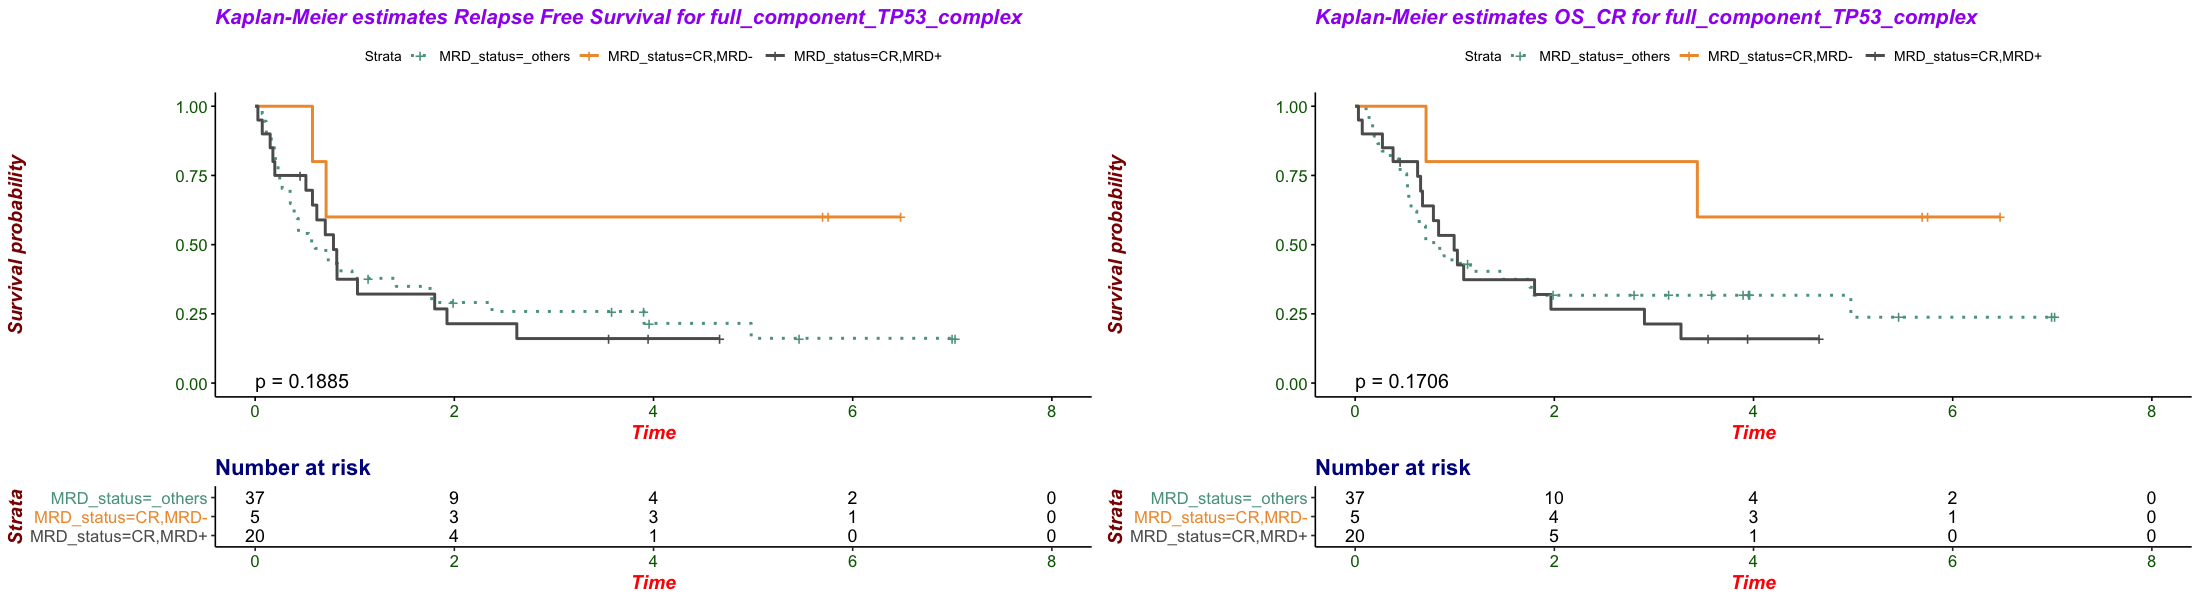

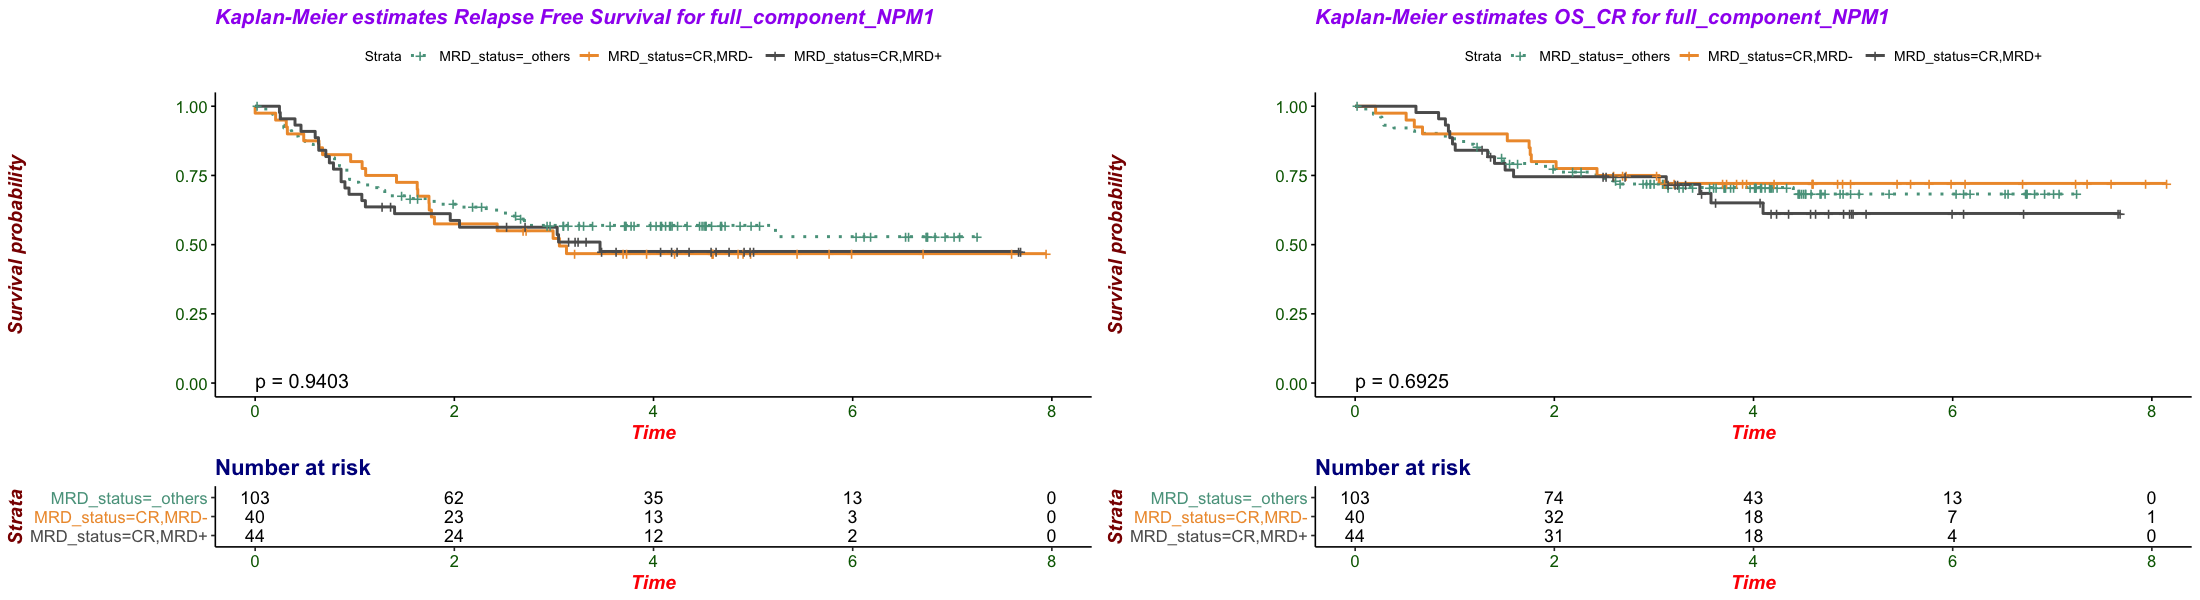

Warning message in max(event[who2]):
“no non-missing arguments to max; returning -Inf”

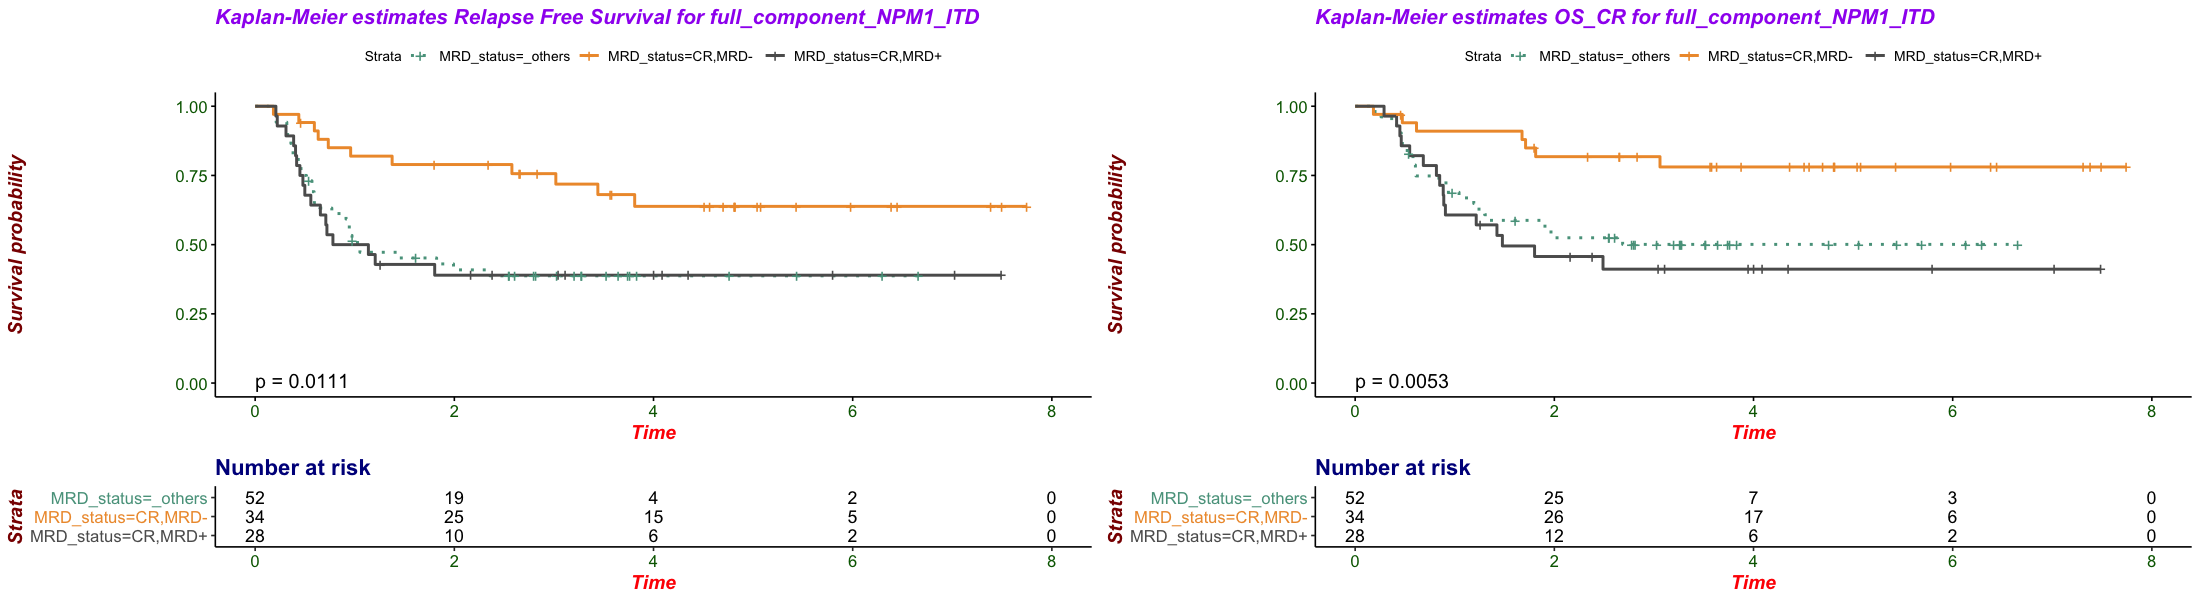

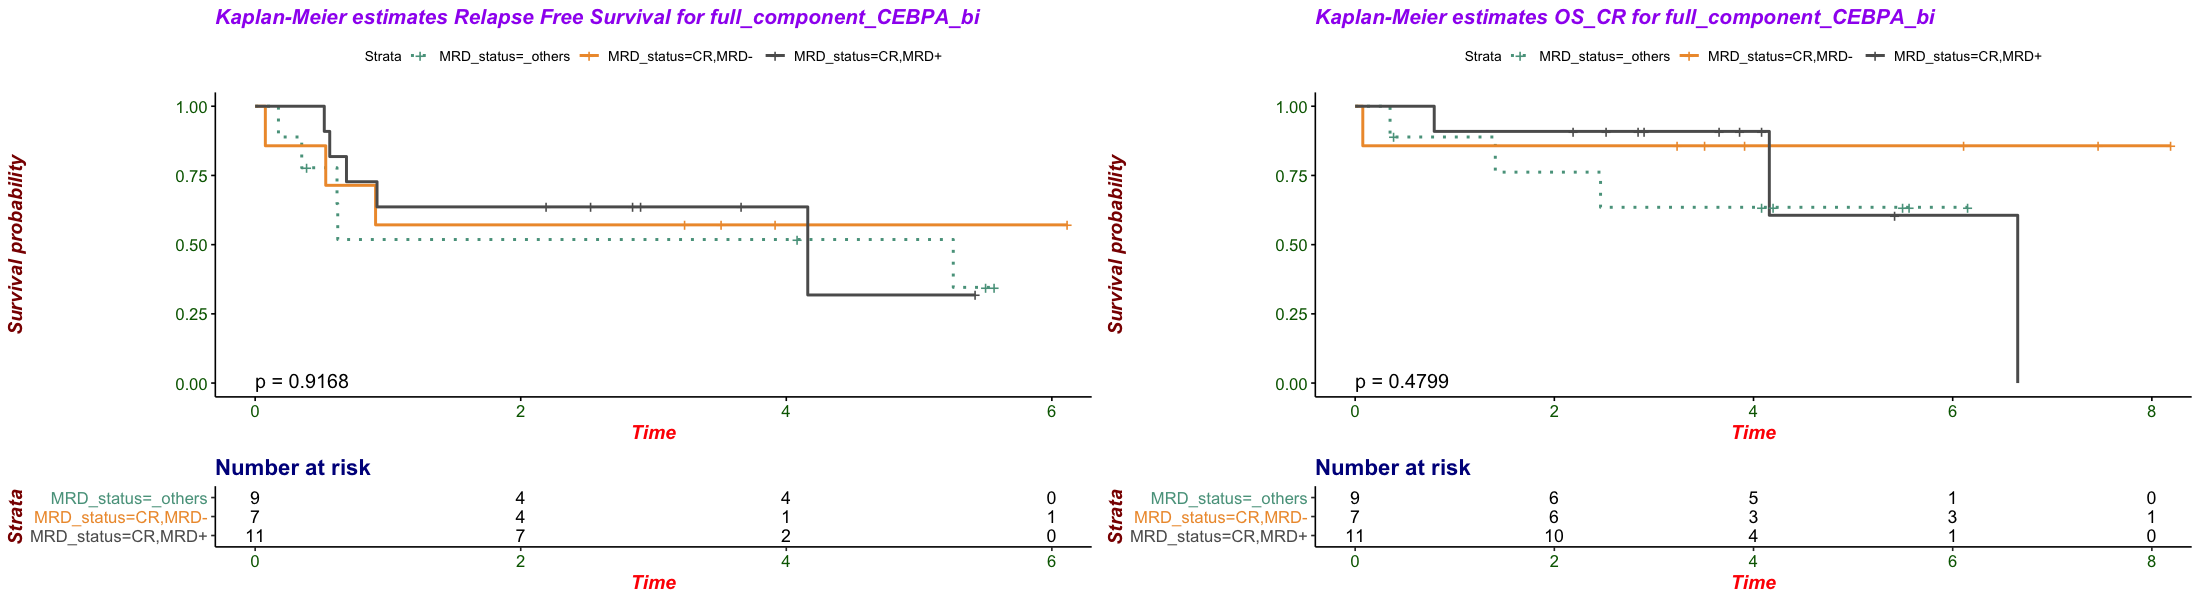

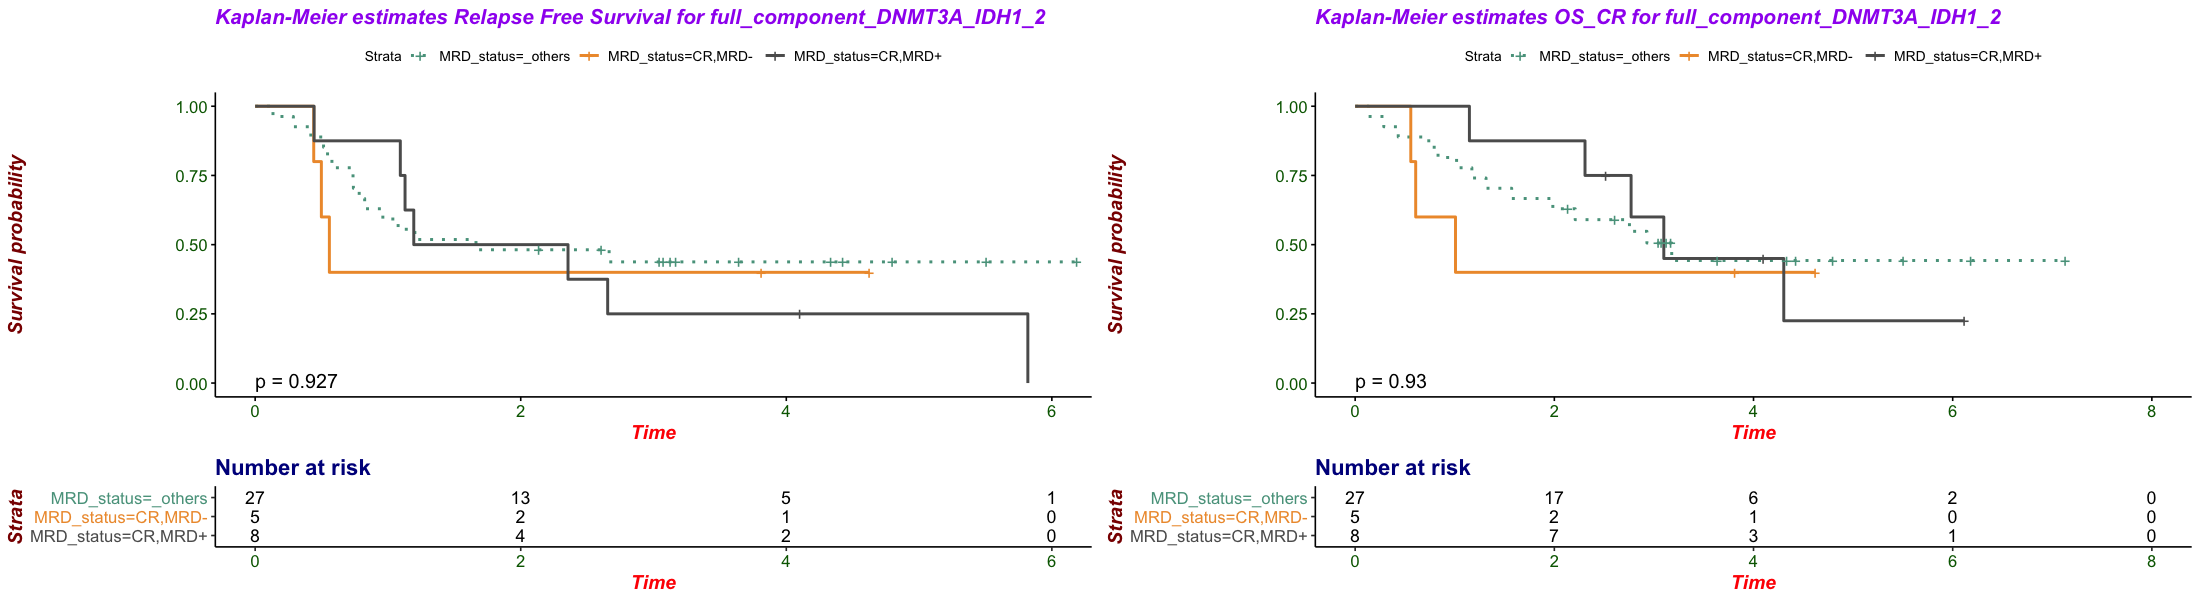

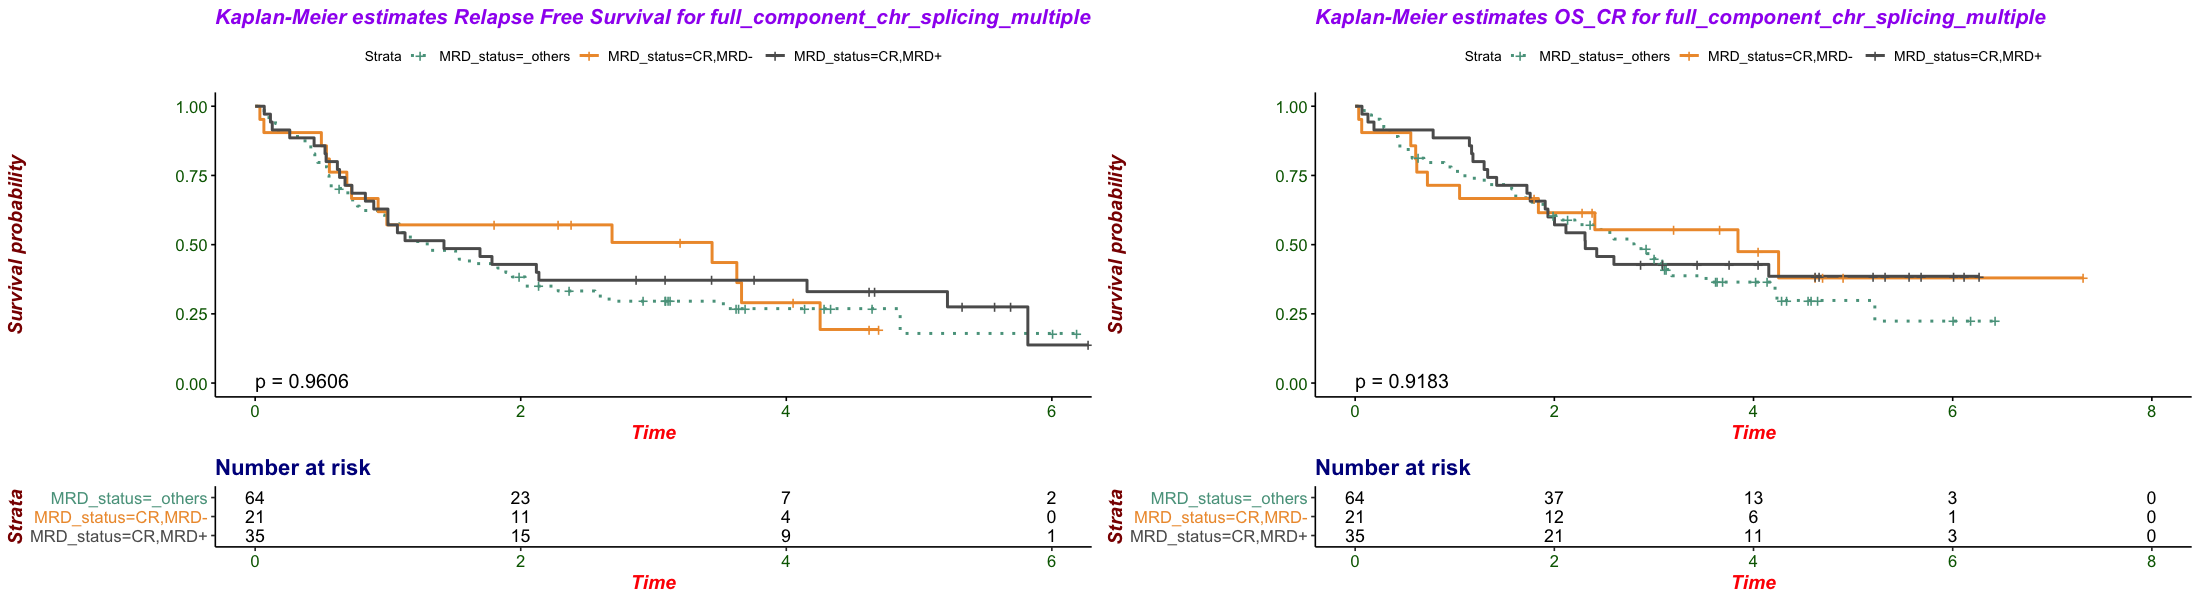

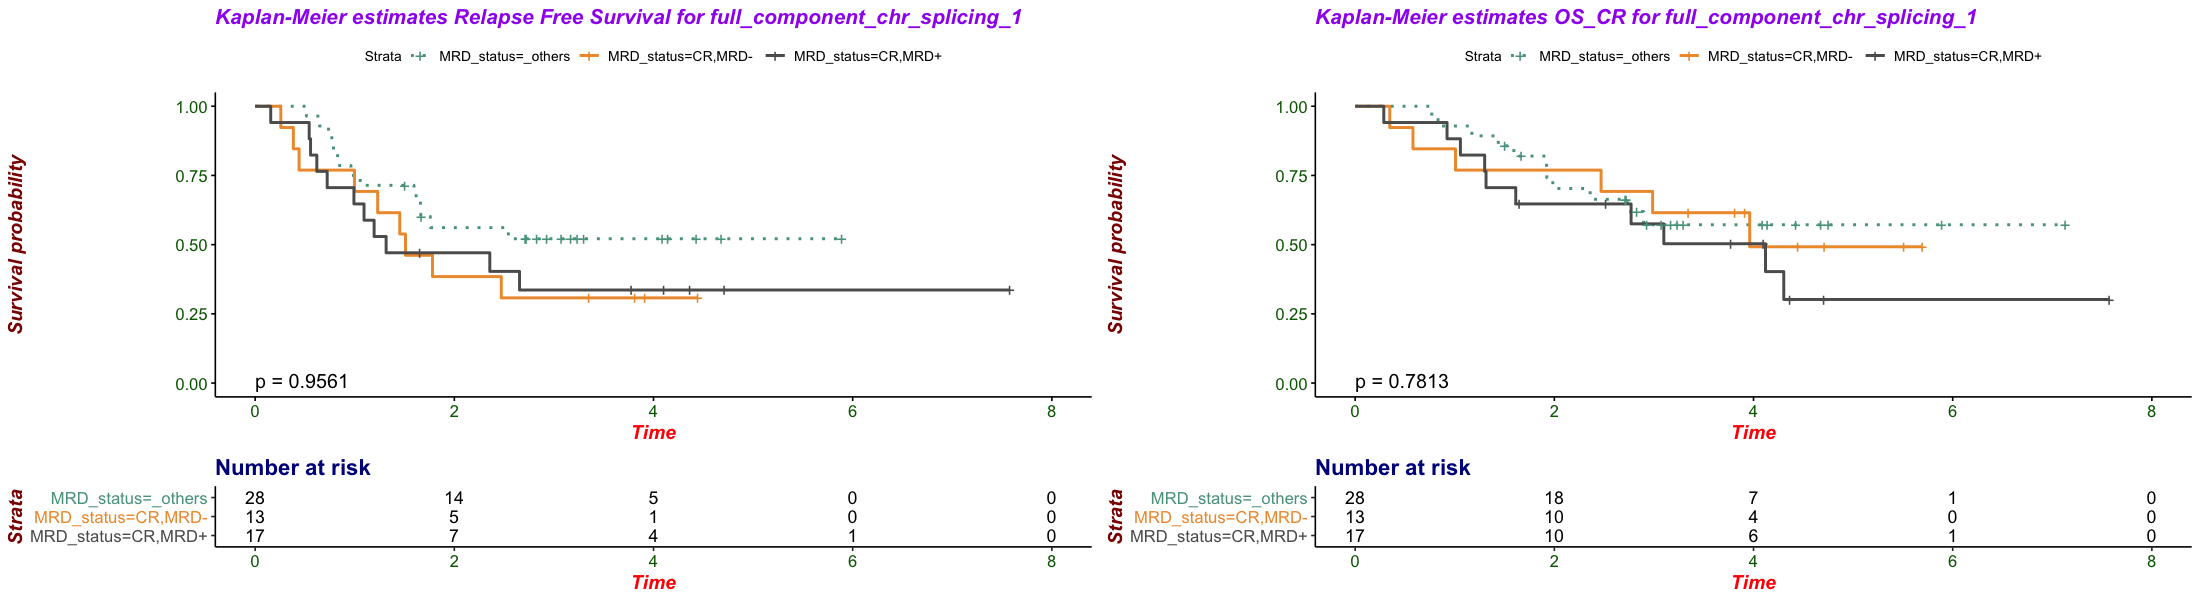

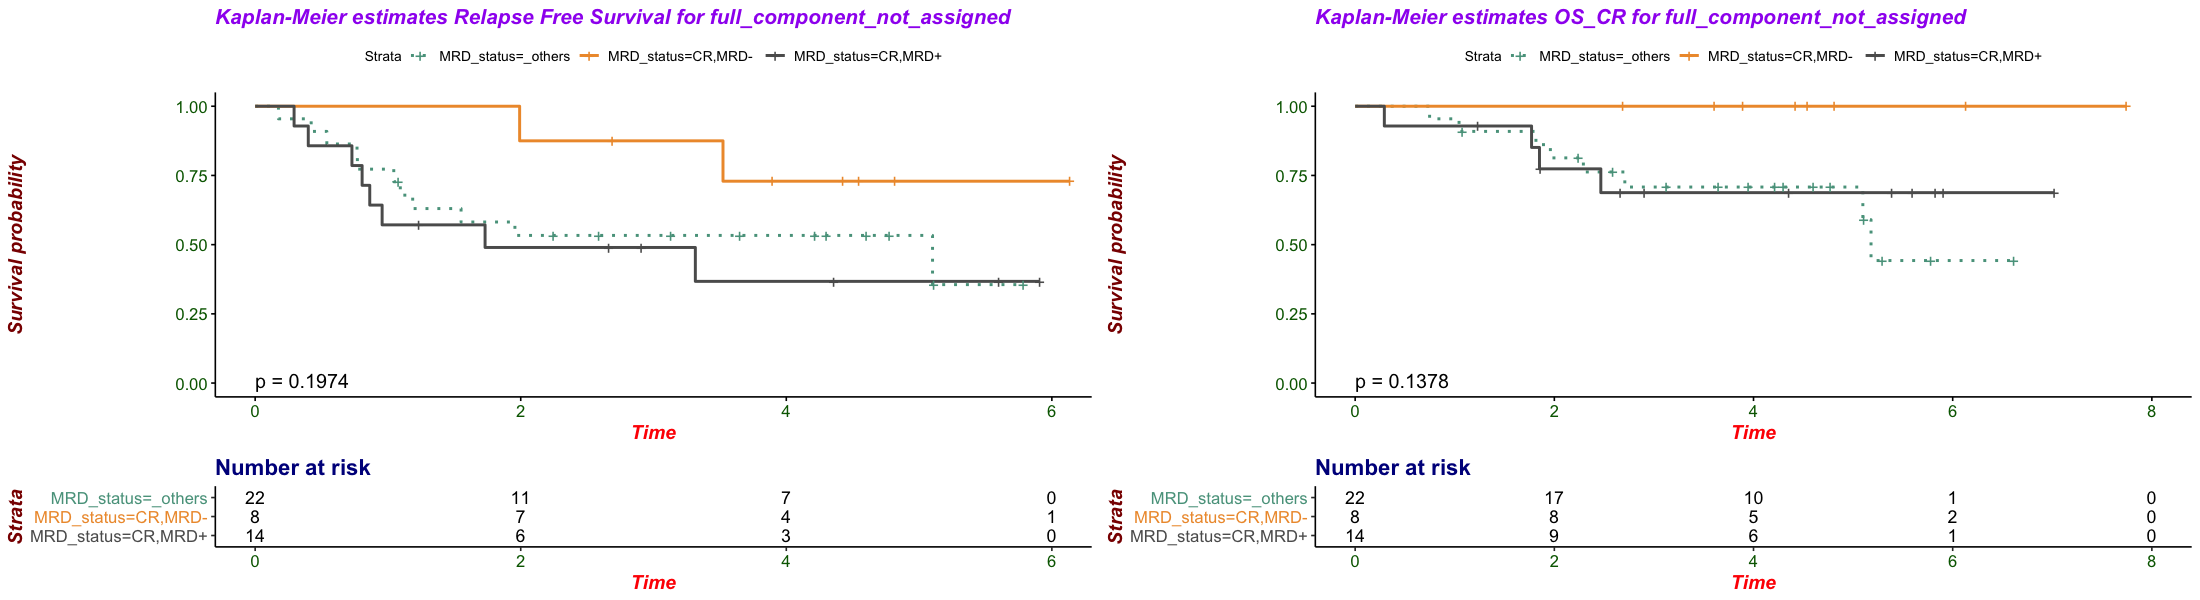

In [123]:
comp <- colnames(df_merge[,170:192])
# pdf("graphs/MRD/components_MRD.pdf",22,6)
for (ev in comp){
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=ev)
    }
# dev.off()

# CR MRD Special Selection Positive no matter MRD

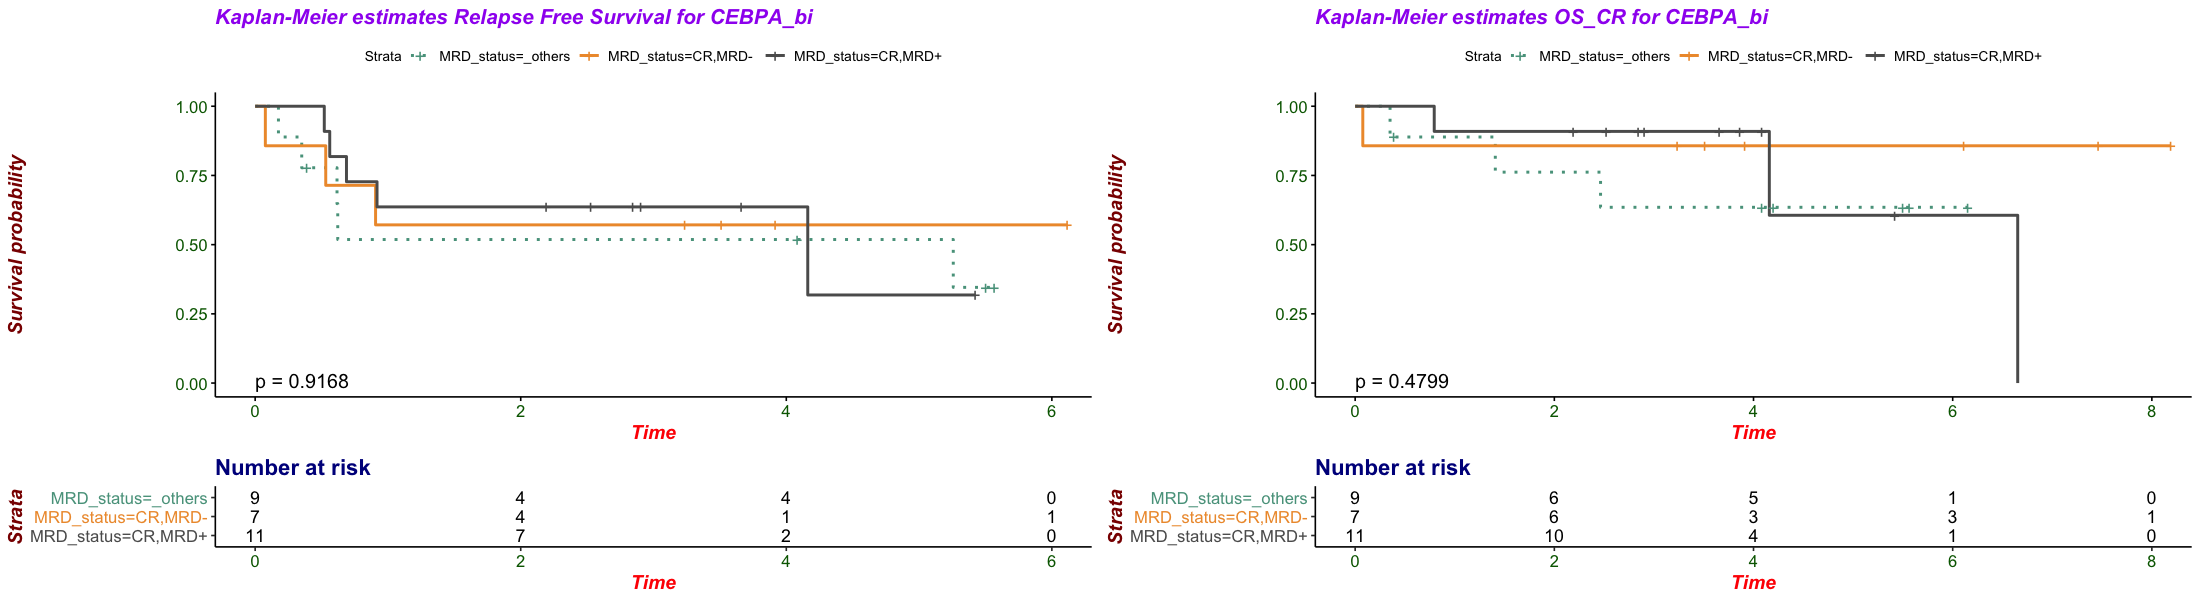

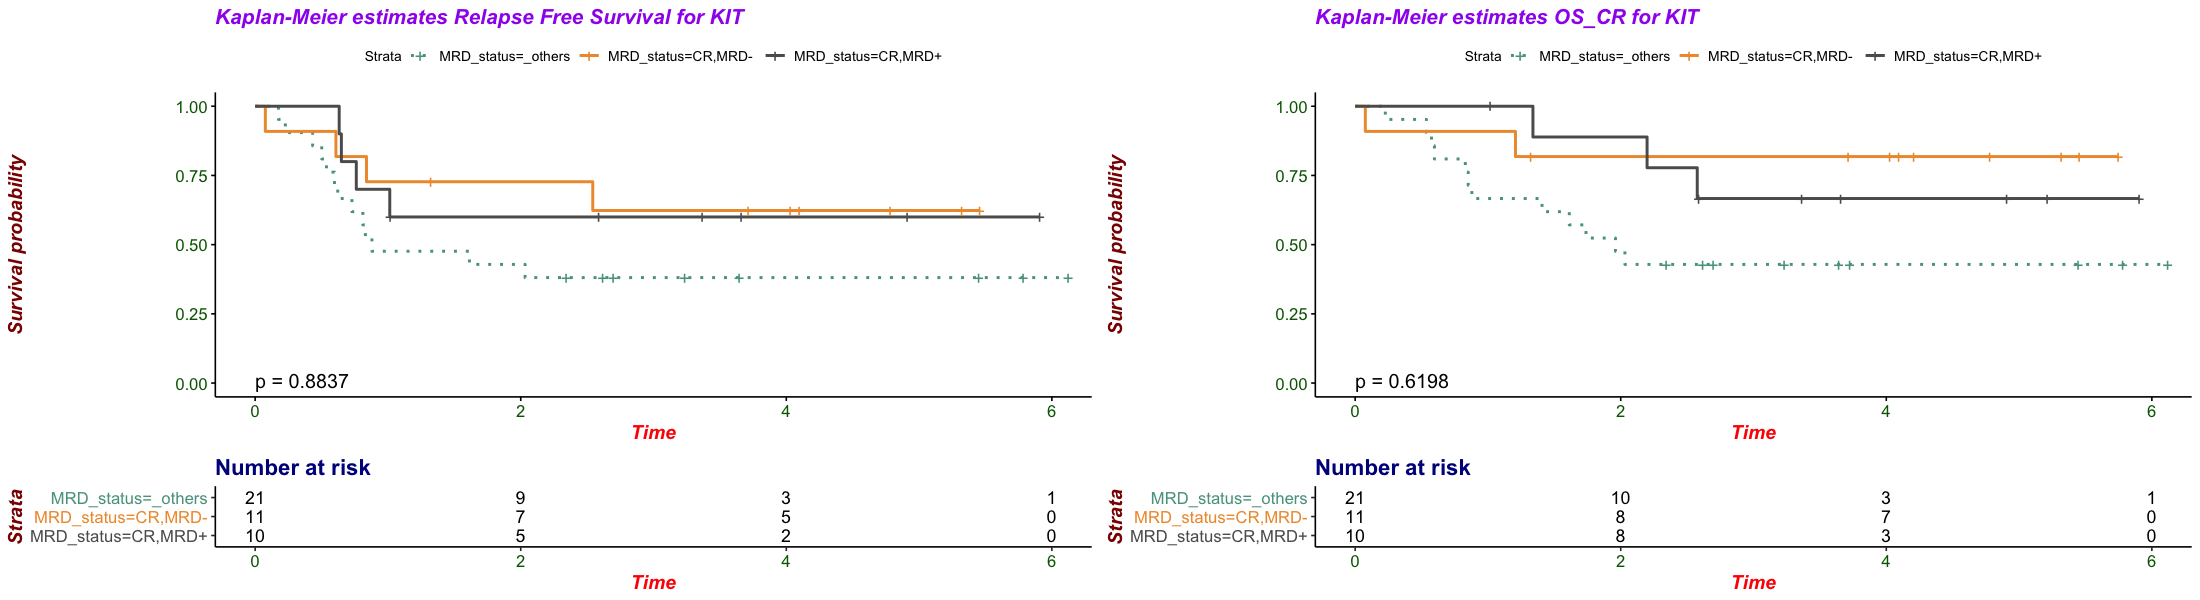

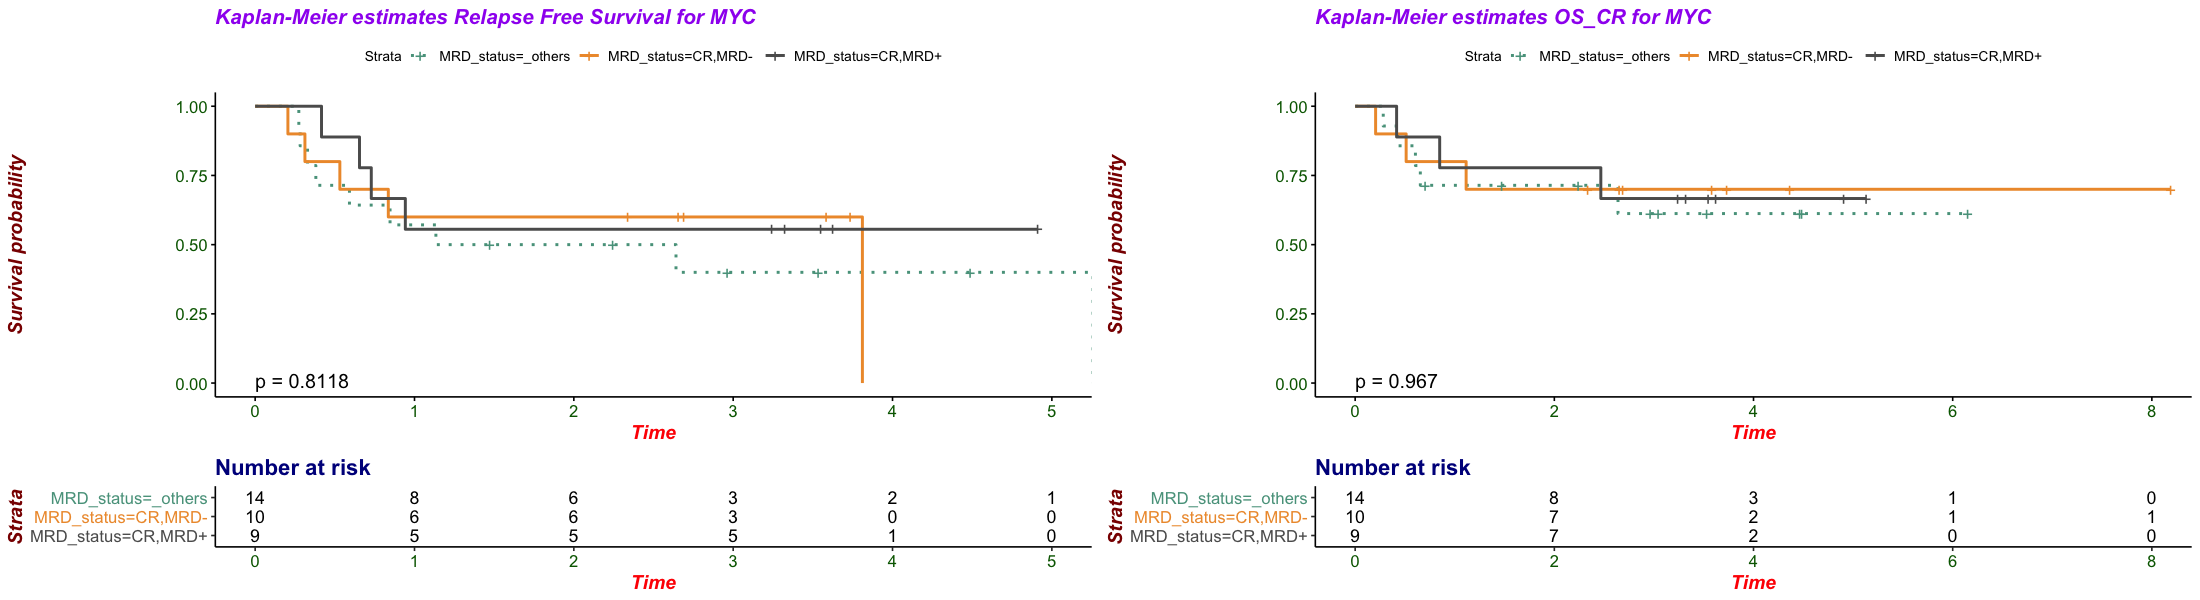

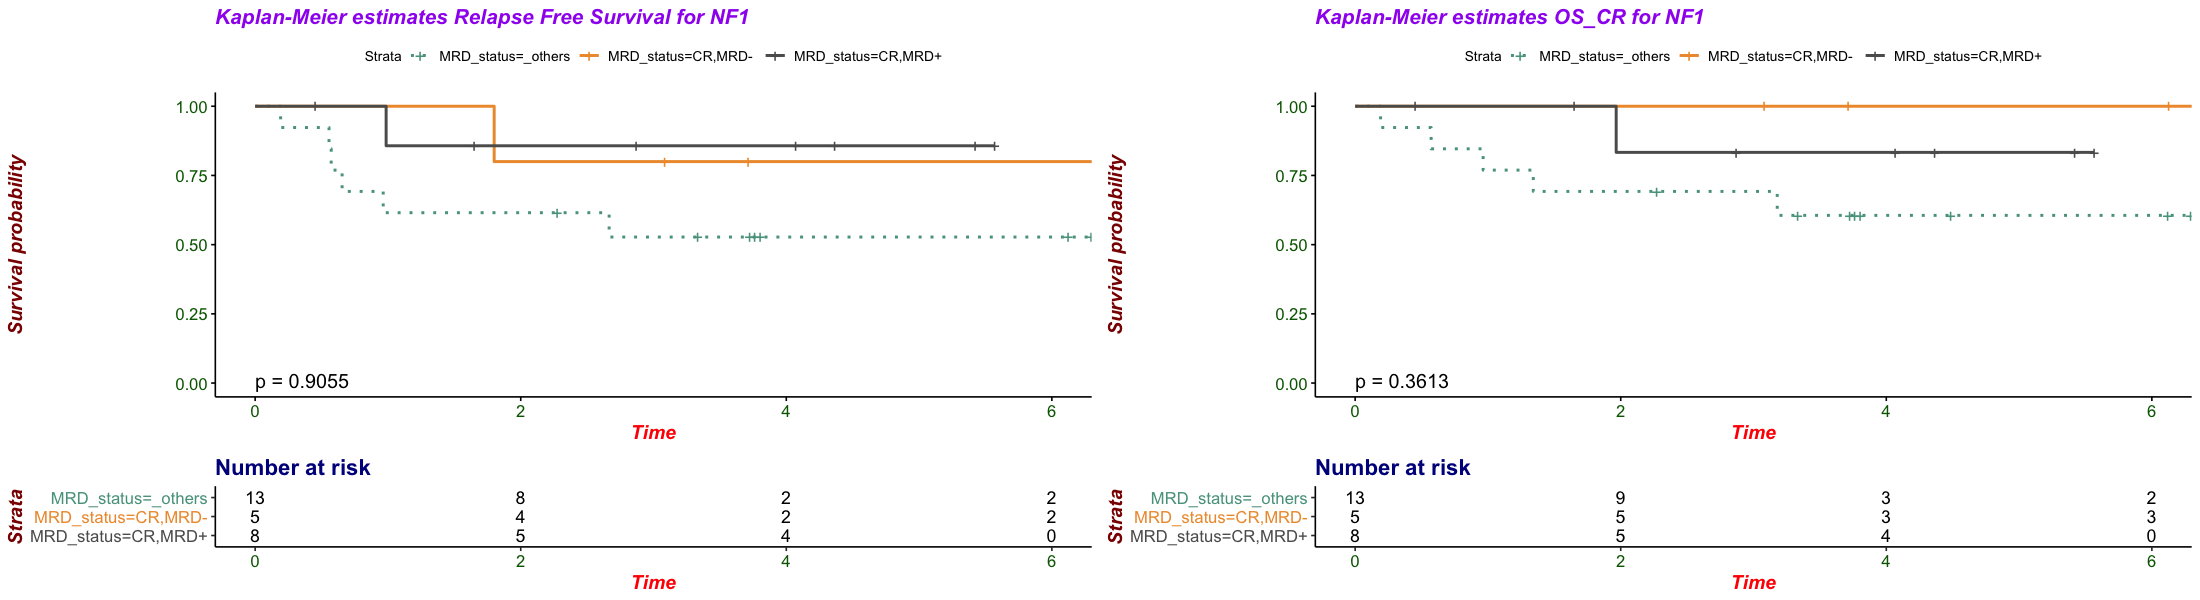

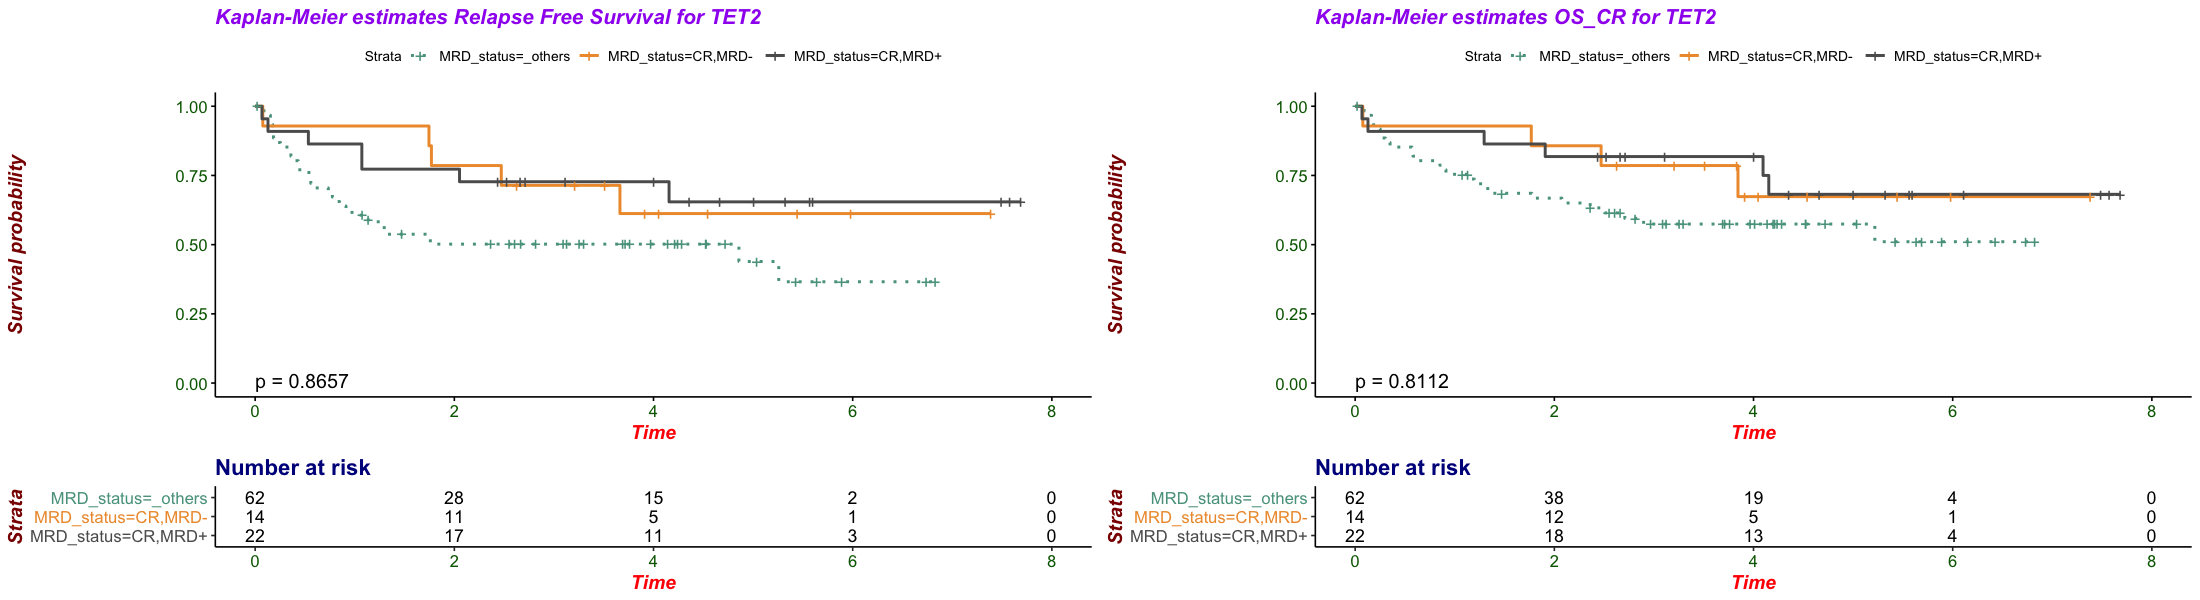

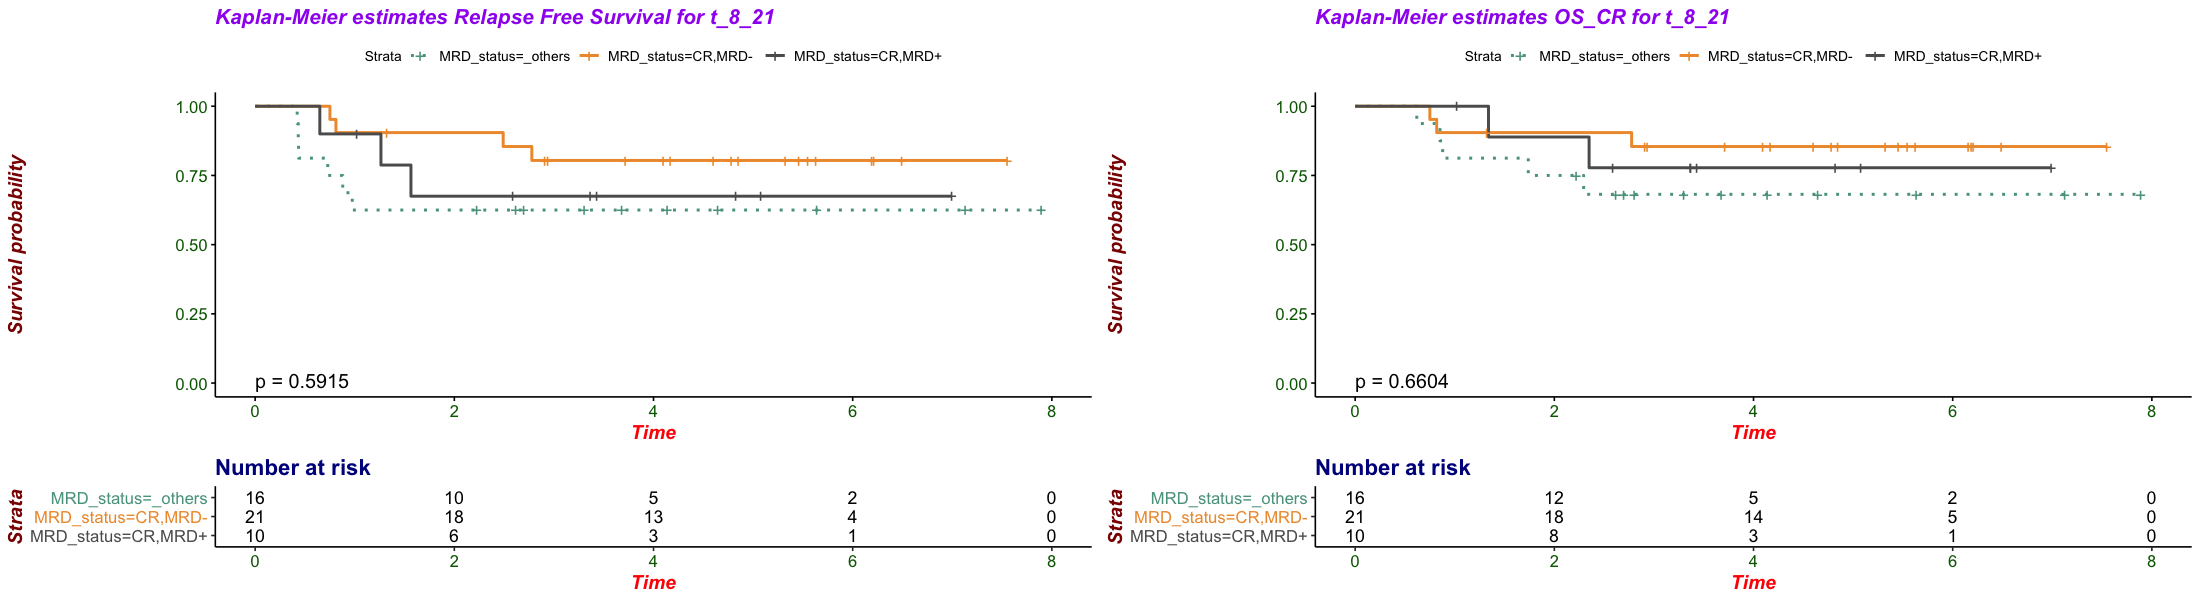

In [124]:
set_notebook_plot_size(22,6)
# pdf("graphs/MRD/interesting_good_MRD.pdf",22,6)
gene_cyto_pos <- c("CEBPA_bi","KIT","MYC","NF1","TET2","t_8_21")
for (ev in gene_cyto_pos){
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=ev)
    }
# dev.off()

# CR MRD Special Selection Negative no matter MRD

In [107]:
set_notebook_plot_size(22,6)
gene_cyto_neg <- c("SRSF2","STAG2","WT1","minusy")
pdf("graphs/MRD/interesting_poor_MRD.pdf",22,6)
for (ev in gene_cyto_neg){
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=ev)
    }
dev.off()

pdf 
  2

# CR MRD Stratification by genes and cyto events

In [108]:
set_notebook_plot_size(22,6)
gene_cyto <- colnames(df_merge[,c(5:158)])
pdf("graphs/MRD/gene_cyto_MRD.pdf",22,6)
for (event in gene_cyto){
    tmp<- df_merge[df_merge[,ev]==1,]
    surv_object <- Surv(time = tmp$RFSyears, event = tmp$RFSStatus)
    fit <- survfit(surv_object ~ MRD_status, data = tmp)
    plots_KM_MRD(tmp=tmp,fit=fit,strat=ev)
    }
dev.off()

pdf 
  2